In [29]:
import torch

from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets
from torchvision import transforms

In [38]:
cfg = {}
cfg['img_dir'] = '/dgx/shared/momo/Data/MVTEc/bottle/train/good'
cfg['batch_size'] = 1
cfg['epochs'] = 5
cfg['device'] = 'cuda:3'

<br>

## Define Teacher Network

In [39]:
pretrained_vgg = models.vgg19(pretrained=True)
teacher = pretrained_vgg.features[:36]
teacher = teacher.to(cfg['device'])
print('\n Full feature layers in vgg19 \n', pretrained_vgg.features)
print('\n Teacher network \n', teacher)


 Full feature layers in vgg19 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): 

<br>

## Define Student Network

In [40]:
vgg = models.vgg19(pretrained=False)
student = vgg.features[:36]
student = student.to(cfg['device'])
print('\n Full feature layers in vgg19 \n', vgg.features)
print('\n Student network \n', student)


 Full feature layers in vgg19 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): 

<br>

## Prepare Dataset

In [41]:
import cv2
import albumentations as albu

from pathlib import Path
from torch.utils.data import Dataset


class MVTecDataset(Dataset):
    
    def __init__(self,
                 img_dir: Path,
                 augmentations: albu.Compose = None,
                 preprocessing: albu.Compose = None) -> None:
        
        self.img_paths = [p for p in img_dir.glob('*.png')]
        self.augmentations = augmentations
        self.preprocessing = preprocessing

        
    def __getitem__(self, 
                    idx: int):
            
            # The original image from the dataset has RGB channels, but flipped in the form of BGR. 
            # So, we use CV2 to revert back to the standard RGB.
            img_path = str(self.img_paths[idx])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if self.augmentations:
                sample = self.augmentations(image=img)
                img = sample['image']

            if self.preprocessing:
                sample = self.preprocessing(image=img)
                img= sample['image']

            return img
        
        
    def __len__(self) -> int:
        
        return len(self.img_paths)

In [42]:
from albumentations.pytorch import ToTensorV2

train_augs = [albu.HorizontalFlip(p=0.5),
              albu.CenterCrop(height=900, width=900, always_apply=True, p=1)]
train_augs = albu.Compose(train_augs)    

preprocessing = [albu.Normalize(always_apply=True, p=1),
                 ToTensorV2()]
preprocessing = albu.Compose(preprocessing)

In [43]:
mvtec = MVTecDataset(img_dir=Path(cfg['img_dir']),
                     augmentations=train_augs,
                     preprocessing=preprocessing)

train_loader = DataLoader(dataset=mvtec,
                          batch_size=cfg['batch_size'],
                          shuffle=True)

<br>

## Train Student Network

In [44]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

In [45]:
teacher.eval()

for epoch in range(cfg['epochs']):
    for i, img in enumerate(train_loader):
         
        img = img.to(cfg['device'])
        with torch.no_grad():
            surrogate_label = teacher(img)
        optimizer.zero_grad()
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        loss.backward()
        optimizer.step()

    print(f'epoch: {epoch}')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4


<br>

## Measure Anomaly Score

In [46]:
from albumentations.pytorch import ToTensorV2

test_augs = [albu.HorizontalFlip(p=0.5),
              albu.CenterCrop(height=900, width=900, always_apply=True, p=1)]
test_augs = albu.Compose(train_augs)    

In [56]:
test_loader = {}

for key in ['good', 'broken_large', 'broken_small', 'contamination']:
    
    mvtec = MVTecDataset(img_dir=Path(f'/dgx/shared/momo/Data/MVTEc/bottle/test/{key}'),
                         augmentations=train_augs,
                         preprocessing=preprocessing)

    test_loader[key] = DataLoader(dataset=mvtec,
                                  batch_size=cfg['batch_size'],
                                  shuffle=True)

In [58]:
teacher.eval()
student.eval()

losses = {'good': [],
          'broken_large': [],
          'broken_small': [],
          'contamination': []}

for key in losses.keys():
    print(key)
    for i, img in enumerate(test_loader[key]):
        with torch.no_grad():
            img = img.to(cfg['device'])
            surrogate_label = teacher(img)
            pred = student(img)
            loss = criterion(pred, surrogate_label)
            losses[key].append(loss.item())

good
broken_large
broken_small
contamination


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


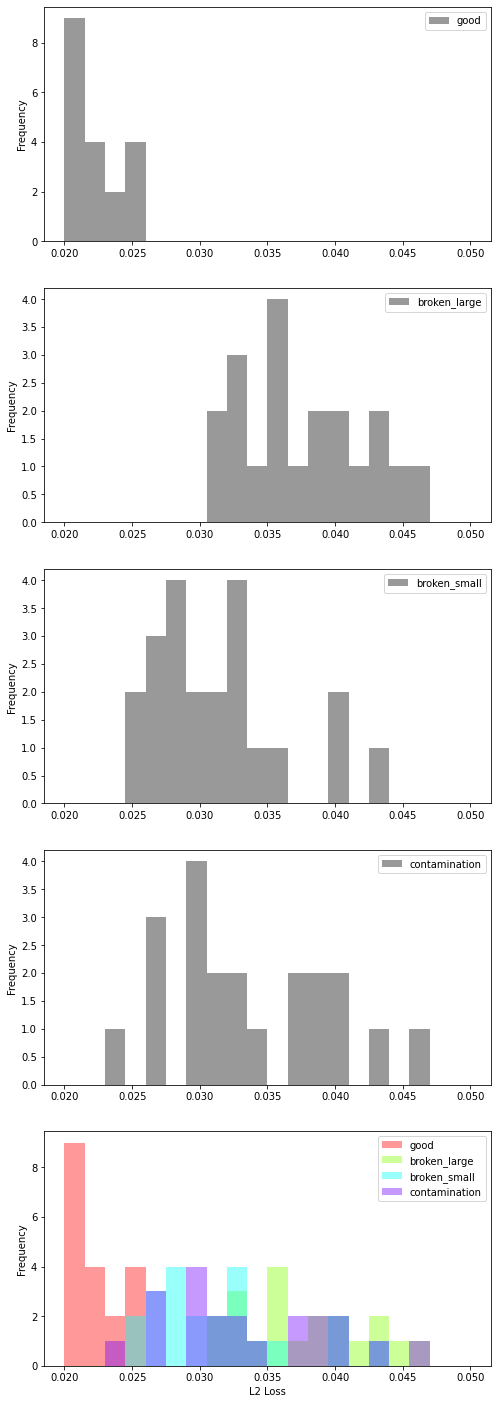

In [68]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(8, 25))
for i, key in enumerate(losses.keys()):
    
    plt.subplot(5, 1, i+1)
    plt.hist(losses[key], range=(0.02, 0.05), label=key, bins=20, color='k', alpha=0.4)
    plt.legend()
    plt.ylabel('Frequency')
    
    plt.subplot(5, 1, 5)
    color = cm.hsv(i/len(losses))
    plt.hist(losses[key], range=(0.02, 0.05), label=key, bins=20, color=color, alpha=0.4)

plt.legend()
plt.xlabel('L2 Loss')
plt.ylabel('Frequency')
plt.show()

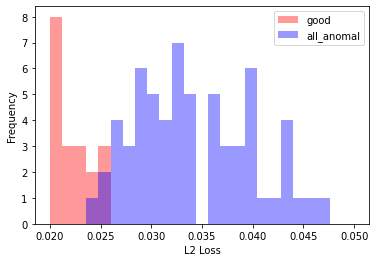

In [77]:
all_anomal = []
all_anomal.append(losses['broken_large'])
all_anomal.append(losses['broken_small'])
all_anomal.append(losses['contamination'])
all_anomal = sum(all_anomal, [])

plt.hist(losses['good'], range=(0.02, 0.05), label='good', bins=25, color='r', alpha=0.4)
plt.hist(all_anomal, range=(0.02, 0.05), label='all_anomal', bins=25, color='b', alpha=0.4)
plt.legend()
plt.xlabel('L2 Loss')
plt.ylabel('Frequency')
plt.show()